# CIS9650 Final Project
Project Deadline: 05/17/21 (11:59pm)

Contributors:
Wei Bin Li, Sophia Newman, Jonathan Satizabal

In [ ]:
#!pip install alpha_vantage
#!pip install yfinance

In [ ]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import datetime
import requests
from alpha_vantage.timeseries import TimeSeries
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import yfinance as yf


### Functions created for project
Below are the functions created that will be used later on in the code.

**Stock functions**
1. **getstock** is a function that calls the Alpha vantage API to retrieve the daily price of the stock from January 1st of 2019 to December 31 of 2019. 
It also change the column names and includes a new column called percentage change in closing price. It takes on one parameter, which is the ticker of the stock. 

2. **plotStock** is a function that plots the percentage change in closing price of the stock vs the time as a bar plot. It takes one parameter, which is the stock ticker

3. **merge** is a function that will combine the closing price of your stock ticker to the closing price of the SP 500 into one pandas dataframe. It will allow you to plot using seaborn. It takes one parameter, which is the stock you want to merge with the SP 500. 

**Crypto functions**
1. **get_crypto_data** is a function that does the same thing as the getstock function but retrieves crypto data from the Alpha vantage API. It will also delete columns such as: "1b. open (USD)","2b. high (USD)", "3b. low (USD)" , "4b. close (USD)", "5. volume", "6. market cap (USD)" and renames them to:
"open", "high", "low", and "close". This function takes two parameters, the crypto currency symbol and the currency you wish to exchange to (i.e. USD, EUR, CNY, etc.). USD = united states dollars, EUR = euro, CNY = chinese yuan etc. 

2. **plotcrypto** is a function that does the same thing as the plotStock function but with crypto data. It takes one parameter, which is the crypto currency symbol.

3. **mergeCrypto** is a function similar to the merge function for stocks but it does it with the crypto currency of your choice and the SP 500. Since there is 365 trading days for crypto currency and there are 252 trading days in the stock exchange, we had to use .loc[1:252] on the crypto currency to match the number of trading days on the stock exchange. 

**Foreign currency functions**
1. **get_fx_data** is a function that retrives currency data and converts the values into another currency. For example, converting chinese yuan (CNY) to United States Dollars (USD). It takes two parameters 'from_currency' and 'to_currency'. 

2. **plotcurrency** is a function that does the same thing as the plotStock function but with foreign currency data. It takes one parameter, which is the foreign currency ticker symbol.

3. **mergeCurrency** is a function similar to the merge function for stocks but it does it with the foreign currency of your choice and the SP 500. Since there is 365 trading days for foreign currency and there are 252 trading days in the stock exchange, we had to use .loc[1:252] on the foreign currency to match the number of trading days on the stock exchange. 


**General functions:**
1. **linearRegression** is a function that finds the slope, intercept, R^2, and the mean square error of your desire asset (x) and the SP 500 (y). It takes two parameters, x and y. 



In [ ]:
# APIs limited 5 calls per minute
# which is why we have 
# four API keys: IJVYA70VH6LPPS4W, V66JKSAVB9ISAQT9, 
# BXXYAY9WTRDO40L4, 6S4FV6XVY0ITGRT7

# stock --> worked with library

# function to get STOCK data using an API key
def getstock(stock): 
  api_key = 'BXXYAY9WTRDO40L4'
  ts = TimeSeries(key = api_key, output_format = 'pandas')
  data, meta_data = ts.get_daily(symbol = stock, outputsize = 'full')
  columns = ['open', 'high', 'low','close', 'volume']
  data.columns = columns
  data = pd.DataFrame(data.loc['2019-12-31':'2019-01-01'])
  data = data.iloc[::-1]
  percentage_change = data['close']/data['close'].shift(1)-1
  percentage_change = percentage_change*100
  data[f'% change in close in {stock}'] = percentage_change
  data = pd.DataFrame(data)
  data = data.reset_index()
  return data

In [ ]:
# function to get CRYPTOs
# crypto --> worked w/ online api

def get_crypto_data(symbol, market):
    api_key = "V66JKSAVB9ISAQT9"
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={market}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T

    for i in df.columns:
        df[i] = df[i].astype(float)

    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1]
    df = df.loc['2019-01-01': '2019-12-31']
    
    columns_to_drop = ["1b. open (USD)","2b. high (USD)", "3b. low (USD)" , "4b. close (USD)", "5. volume", "6. market cap (USD)"]
    df = df.drop(columns = columns_to_drop)
    df.rename(columns={'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close'}, inplace=True)
    
    percentage_change = df['close']/df['close'].shift(1)-1
    percentage_change = percentage_change*100
    df[f'% change in close in {symbol}'] = percentage_change
    
    df = pd.DataFrame(df)
    df = df.reset_index()
    df.rename(columns = {'index': 'date'}, inplace = True)
    
    return df

In [ ]:
def get_fx_data(from_symbol, to_symbol):
    api_key = "6S4FV6XVY0ITGRT7"
    api_url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={from_symbol}&to_symbol={to_symbol}&outputsize=full&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series FX (Daily)']).T

    for i in df.columns:
        df[i] = df[i].astype(float)

    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1]
    df = df.loc['2019-01-01': '2019-12-31']
    
    percentage_change = df['4. close']/df['4. close'].shift(1)-1
    percentage_change = percentage_change*100
    df[f'% change in close in {from_symbol}'] = percentage_change
    
    df = df.reset_index()
    df.rename(columns = {'index': 'date'}, inplace = True)
    df = df.iloc[0:252]
    
    return df

In [ ]:
# function to plot stock % change data

def plotStock(stock):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(getstock(stock)['date'], getstock(stock)[f'% change in close in {stock}'], color = 'blue')
  plt.title(f'% change in closing price vs date for {stock}')
  plt.xlabel("date")
  plt.ylabel("% change in closing price")
  return plt.show()

In [ ]:
# function to plot crypto % change data

def plotcrypto(crypto):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(get_crypto_data(crypto, 'USD')['date'],get_crypto_data(crypto, 'USD')[f'% change in close in {crypto}'],
        color = 'k')
  plt.title(f'% change in closing price vs date for {crypto}')
  plt.xlabel("date")
  plt.ylabel("% change in closing price")
  return plt.show()

In [ ]:
# function to plot crypto % change data 

def plotcurrency(currency):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(get_fx_data(currency, 'USD')['date'],get_fx_data(currency, 'USD')[f'% change in close in {currency}'],
        color = 'green')
    plt.title(f'% change in closing price vs date for {currency}')
    plt.xlabel("date")
    plt.ylabel("% change in closing price")
    return plt.show()

In [ ]:
# function to merge % change stock data and % change sp500 data

def merge(stockName):
  stock = getstock(stockName)[f'% change in close in {stockName}']
  SP500 = getstock('SPY')['% change in close in SPY']
  new_stock = stock.iloc[1:]
  SP500 = SP500.iloc[1:]
  new_stock = np.array([new_stock,SP500])
  new_stock = new_stock.transpose()
  new_stock = pd.DataFrame(new_stock, columns = [f'% change in close in {stockName}','% change in close in SPY'])

  return new_stock

In [ ]:
# function to merge % change stock data and % change sp500 data

def mergeCrypto(symbol):
  crypto = get_crypto_data(symbol, 'USD')[f'% change in close in {symbol}']
  SP500 = getstock('SPY')['% change in close in SPY']
  new_crypto = crypto.iloc[1:252]
  SP500 = SP500.iloc[1:]
  new_crypto = np.array([new_crypto,SP500])
  new_crypto = new_crypto.transpose()
  new_crypto = pd.DataFrame(new_crypto, columns = [f'% change in close in {symbol}','% change in close in SPY'])

  return new_crypto

In [ ]:
# function to merge currency and sp500 data

def mergeCurrency(currency):
    fx = get_fx_data(currency, 'USD')[f'% change in close in {currency}']
    SP500 = getstock('SPY')['% change in close in SPY']
    
    new_currency = fx.iloc[1:252]
    SP500 = SP500.iloc[1:]
    
    #new_currency = new_currency[f'% change in close in {currency}']
    new_currency = np.array([new_currency, SP500])
    new_currency = new_currency.transpose()
    new_currency = pd.DataFrame(new_currency, columns = [f'% change in close in {currency}','% change in close in SPY'])
    
    return new_currency

In [ ]:
# function to figure out slope and intercept of asset we're looking at and sp500
# x = asset (ticker)
# y = sp500 (ticker)

# x and y have to be 1 dimentional row / vector
# have to have same number of rows

def linearRegression(x,y):
  x = np.array(x)
  n = np.size(x)
  x_mean = np.mean(x)
  y_mean = np.mean(y)
  x_mean,y_mean
  
  Sxy = np.sum(x*y)- n*x_mean*y_mean
  Sxx = np.sum(x*x)-n*x_mean*x_mean
  
  b1 = Sxy/Sxx
  b0 = y_mean-b1*x_mean
  y_pred = b1 * x + b0

  error = y - y_pred
  se = np.sum(error**2)
  mse = se/n 

  SSt = np.sum((y - y_mean)**2)
  R2 = 1- (se/SSt)

  return b0,b1,mse,R2

# 1. Collecting Data

### 1a. Choose 5  equities or assets 
Choose 5 distinct equities or assets(oil, gold, bonds, currency pairs, bitcoins, etc…). Verify there is data available to import from Quandl, Alpha Vantage or Yahoo Finance.

### 1b. Import Data
Import daily prices (adj closing or spot) for all 5 assets. Use **1/1/2019** as the start date and **12/31/2019** as the end date. Display the first 5 rows and the total count for each asset.

### 2a. Calulate Daily % Change
Calculate daily % change for each of the assets and the SP500. Display the first 5 rows and the total count for each data set.



***Above 3 steps done in below 1 step using getstock, get_crypto_data, get_fx_data***

In [ ]:
# Microsoft (Data first 5 rows)
MSFT_data = getstock('MSFT')
MSFT_data.head()

,date,open,high,low,close,volume,% change in close in MSFT
0,2019-01-02,99.55,101.75,98.94,101.12,35329345.0,NaN
1,2019-01-03,100.10,100.19,97.20,97.40,42578410.0,-3.678797
2,2019-01-04,99.72,102.51,98.93,101.93,44060620.0,4.650924
3,2019-01-07,101.64,103.27,100.98,102.06,35656136.0,0.127539
4,2019-01-08,103.04,103.97,101.71,102.80,31514415.0,0.725064


In [ ]:
# Bitcoin(Data first 5 rows)
BTC_data = get_crypto_data('BTC', 'USD')
BTC_data.head()

,date,open,high,low,close,% change in close in BTC
0,2019-01-01,3701.23,3810.16,3642.00,3797.14,NaN
1,2019-01-02,3796.45,3882.14,3750.45,3858.56,1.617533
2,2019-01-03,3857.57,3862.74,3730.00,3766.78,-2.378608
3,2019-01-04,3767.20,3823.64,3703.57,3792.01,0.669803
4,2019-01-05,3790.09,3840.99,3751.00,3770.96,-0.555115


In [ ]:
# Ethereum 
ETH_data = get_crypto_data('ETH', 'USD')
ETH_data.head()

,date,open,high,low,close,% change in close in ETH
0,2019-01-01,131.45,140.67,130.00,139.10,NaN
1,2019-01-02,139.10,155.37,137.76,152.01,9.281093
2,2019-01-03,152.01,153.64,143.11,146.30,-3.756332
3,2019-01-04,146.30,154.80,143.54,151.97,3.875598
4,2019-01-05,152.08,159.26,151.20,152.83,0.565901


In [ ]:
# RMB
CNY_data = get_fx_data('CNY', 'USD')
CNY_data.head()

,date,1. open,2. high,3. low,4. close,% change in close in CNY
0,2019-01-01,0.1454,0.1454,0.1453,0.1454,NaN
1,2019-01-02,0.1454,0.1460,0.1453,0.1457,0.206327
2,2019-01-03,0.1457,0.1457,0.1452,0.1455,-0.137268
3,2019-01-04,0.1455,0.1457,0.1455,0.1456,0.068729
4,2019-01-07,0.1459,0.1461,0.1459,0.1459,0.206044


In [ ]:
# Euro
EUR_data = get_fx_data('EUR', 'USD')
EUR_data.head()

,date,1. open,2. high,3. low,4. close,% change in close in EUR
0,2019-01-01,1.14650,1.15450,1.14460,1.14609,NaN
1,2019-01-02,1.14606,1.14968,1.13105,1.13369,-1.081939
2,2019-01-03,1.13330,1.14110,1.13080,1.13932,0.496608
3,2019-01-04,1.13932,1.14191,1.13440,1.13942,0.008777
4,2019-01-07,1.14046,1.14826,1.14020,1.14751,0.710010


In [ ]:
# Print the count for each of the 5 assets

#MSFT_data.describe()

#print('Total Count for MSFT:', getstock('MSFT').shape)
#print('Total Count for MSFT:', getstock('MSFT').size)

#print('Total Count for BTC:', get_crypto_data('BTC', 'USD').shape)
#print('Total Count for BTC:', get_crypto_data('BTC', 'USD').size)

#print('Total Count for ETH:', get_crypto_data('ETH', 'USD').shape)
#print('Total Count for ETH:', get_crypto_data('ETH', 'USD').size)

#print('Total Count for CNY:', get_fx_data('CNY', 'USD').shape)
#print('Total Count for CNY:', get_fx_data('CNY', 'USD').size)

#print('Total Count for CNY:', get_fx_data('EUR', 'USD').shape)
#print('Total Count for CNY:', get_fx_data('EUR', 'USD').size)

### 1c. Import SP500
Import daily prices for SP500. Use **1/1/2019** as the start date and **12/31/2019** as the end date. Display the first 5 rows and the total count of the S&P.

In [ ]:
# SP500 (Data first 5 rows)
SP500_data = getstock('SPY')

SP500_data.head()

,date,open,high,low,close,volume,% change in close in SPY
0,2019-01-02,245.98,251.21,245.95,250.18,126925199.0,NaN
1,2019-01-03,248.23,248.57,243.67,244.21,144140692.0,-2.386282
2,2019-01-04,247.59,253.11,247.17,252.39,142628834.0,3.349576
3,2019-01-07,252.69,255.95,251.69,254.38,103139100.0,0.788462
4,2019-01-08,256.82,257.31,254.00,256.77,102512587.0,0.939539


In [ ]:
# Print the count for SP500 (SPY)


#print('Total Count for SPY:', getstock('SPY').shape)
#print('Total Count for SPY:', getstock('SPY').size)

# 2. Processing Data

### 2a. Calulate Daily % Change
Calculate daily % change for each of the assets and the SP500. Display the first 5 rows and the total count for each data set.
(See Above)

### 2b. Plot Daily % Change
Plot the daily % change data using a bar graph for each asset. (Plot for each asset)

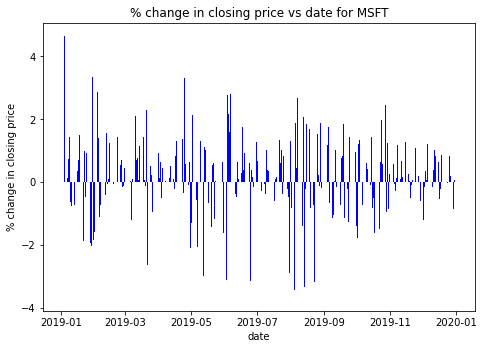

In [ ]:
# use 'plotStock' function to plot MSFT % change
plotStock("MSFT")

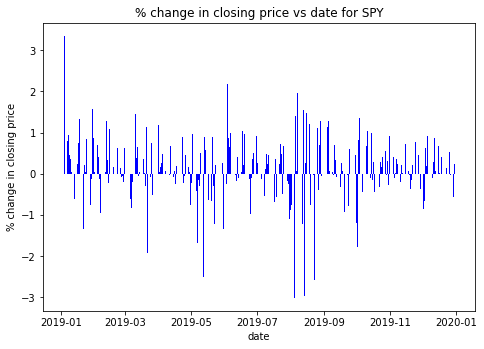

In [ ]:
# use 'plotStock' function to plot SP500 % change
plotStock("SPY")

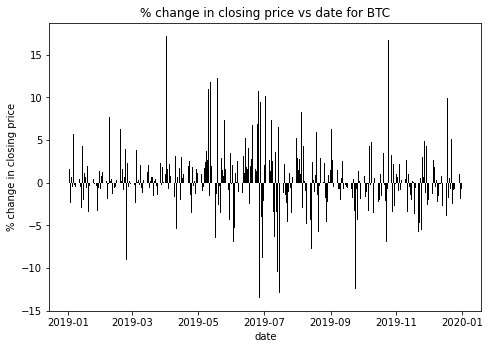

In [ ]:
# use 'plotcrypto' function to plot BTC % change
plotcrypto("BTC")

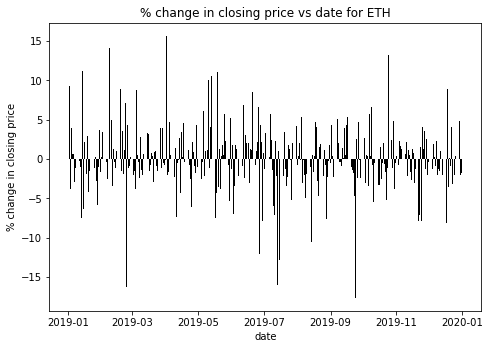

In [ ]:
# use 'plotcrypto' function to plot ETH % change
plotcrypto('ETH')

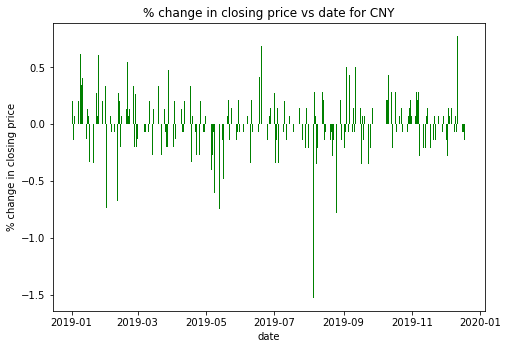

In [ ]:
# use 'plotcurrency' function to plot CNY % change
plotcurrency("CNY")

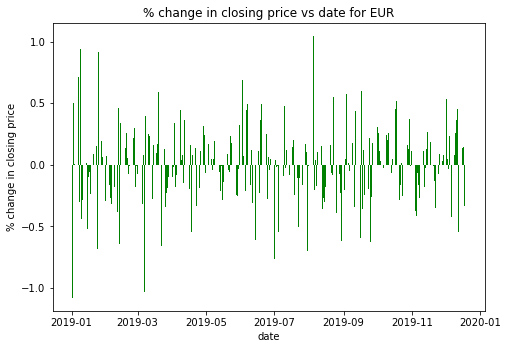

In [ ]:
# use 'plotcurrency' function to plot EUR % change
plotcurrency("EUR")

### 2c. Statistical Summary
Calculate and display the mean, standard deviation, variance, min, and max for each set of data.

In [ ]:
# use 'getstock' to print the basic statistical summary for MSFT
# calculate the variance and print their values
std = getstock("MSFT").std()
variance = std * std
variance = pd.DataFrame(variance)

print(getstock('MSFT').describe(), '\n\nVariance:\n', variance)

             open        high         low       close        volume  \
count  252.000000  252.000000  252.000000  252.000000  2.520000e+02   
mean   130.339048  131.230952  129.303855  130.382024  2.466310e+07   
std     14.995333   14.927131   14.944059   14.900504  7.693475e+06   
min     99.550000  100.190000   97.200000   97.400000  8.989150e+06   
25%    119.307500  119.912500  118.485000  119.340000  1.842638e+07   
50%    134.970000  136.100000  133.575000  135.220000  2.379507e+07   
75%    139.667500  140.365000  138.250000  139.177500  2.842352e+07   
max    159.450000  159.550000  158.220000  158.960000  5.563639e+07   

       % change in close in MSFT  
count                 251.000000  
mean                    0.185048  
std                     1.254968  
min                    -3.678797  
25%                    -0.503651  
50%                     0.142833  
75%                     0.914545  
max                     4.650924   

Variance:
                                 

In [ ]:
# use 'getstock' to print the basic statistical summary for SPY
# calculate the variance and print their values
std = getstock("SPY").std()
variance = std * std
variance = pd.DataFrame(variance)

print(getstock('SPY').describe(), '\n\nVariance:\n', variance)

             open        high         low       close        volume  \
count  252.000000  252.000000  252.000000  252.000000  2.520000e+02   
mean   290.853770  292.053452  289.548309  290.995595  7.028362e+07   
std     15.286478   14.982946   15.410087   15.106196  2.601800e+07   
min    245.980000  248.570000  243.670000  244.210000  2.027001e+07   
25%    281.892500  283.155000  280.327500  281.497500  5.076534e+07   
50%    291.350000  292.820000  290.005000  291.560000  6.506453e+07   
75%    299.772500  300.765000  298.505000  299.907500  8.363440e+07   
max    323.740000  323.800000  322.280000  322.940000  1.787454e+08   

       % change in close in SPY  
count                251.000000  
mean                   0.103555  
std                    0.792183  
min                   -3.007313  
25%                   -0.233313  
50%                    0.077228  
75%                    0.588610  
max                    3.349576   
 open                        2.336764e+02
high       

In [ ]:
# use 'get_crypto_data' to print the basic statistical summary for BTC
# calculate the variance and print their values
std = get_crypto_data('BTC', 'USD').std()
variance = std * std
variance = pd.DataFrame(variance)

print(get_crypto_data('BTC', 'USD').describe(), '\n\n Variance:\n', variance)

               open          high           low         close  \
count    365.000000    365.000000    365.000000    365.000000   
mean    7354.844685   7547.611808   7152.498493   7364.363205   
std     2653.563635   2755.156904   2529.877519   2646.572787   
min     3398.400000   3426.450000   3349.920000   3398.400000   
25%     4144.540000   4897.990000   4140.540000   4857.290000   
50%     7795.620000   8042.320000   7481.020000   7790.710000   
75%     9528.230000   9794.990000   9320.000000   9529.930000   
max    13098.380000  13970.000000  12068.000000  13093.800000   

       % change in close in BTC  
count                364.000000  
mean                   0.239596  
std                    3.595256  
min                  -13.470574  
25%                   -1.319032  
50%                    0.086477  
75%                    1.642837  
max                   17.196759   

 Variance:
                                      0
open                      7.041400e+06
high            

In [ ]:
# use 'get_crypto_data' to print the basic statistical summary for ETH
# calculate the variance and print their values
std = get_crypto_data('ETH', 'USD').std()
variance = std * std
variance = pd.DataFrame(variance)

print(get_crypto_data('ETH', "USD").describe(), '\n\n Variance: ', variance)

             open        high         low       close  \
count  365.000000  365.000000  365.000000  365.000000   
mean   180.917425  186.414849  174.886219  180.906411   
std     50.598343   52.824238   48.103741   50.602983   
min    104.410000  106.180000  100.910000  104.450000   
25%    141.410000  145.070000  137.620000  141.380000   
50%    173.340000  177.440000  168.000000  173.330000   
75%    210.270000  215.830000  202.300000  210.210000   
max    339.530000  366.800000  315.570000  339.390000   

       % change in close in ETH  
count                364.000000  
mean                   0.068652  
std                    4.205934  
min                  -17.626310  
25%                   -1.930281  
50%                   -0.045630  
75%                    1.999945  
max                   15.625885   

 Variance:                                      0
open                      2560.192302
high                      2790.400113
low                       2313.969941
close         

In [ ]:
# use 'get_fx_data' to print the basic statistical summary for CNY
# calculate the variance and print their values
std = get_fx_data('CNY', 'USD').std()
variance = std * std
variance = pd.DataFrame(variance)

print(get_fx_data('CNY','USD').describe(), '\n\nVariance:', variance)

          1. open     2. high      3. low    4. close  \
count  252.000000  252.000000  252.000000  252.000000   
mean     0.144850    0.145060    0.144638    0.144832   
std      0.003126    0.003142    0.003135    0.003129   
min      0.139400    0.139400    0.139100    0.139300   
25%      0.142000    0.142175    0.141800    0.142000   
50%      0.145200    0.145350    0.145000    0.145100   
75%      0.148200    0.148300    0.147750    0.148200   
max      0.149600    0.149900    0.149300    0.149600   

       % change in close in CNY  
count                251.000000  
mean                  -0.007168  
std                    0.245076  
min                   -1.526718  
25%                   -0.136661  
50%                    0.000000  
75%                    0.134454  
max                    0.774648   

Variance:                                  0
1. open                   0.000010
2. high                   0.000010
3. low                    0.000010
4. close                  0.

In [ ]:
# use 'get_fx_data' to print the basic statistical summary for EUR
# calculate the variance and print their values
std = get_fx_data('EUR', 'USD').std()
variance = std * std
variance = pd.DataFrame(variance)

print(get_fx_data('EUR', "USD").describe(), '\n\nVariance:', variance)

          1. open     2. high      3. low    4. close  \
count  252.000000  252.000000  252.000000  252.000000   
mean     1.119927    1.122663    1.116946    1.119747   
std      0.013690    0.013941    0.013500    0.013595   
min      1.089840    1.094280    1.087800    1.089830   
25%      1.108225    1.110968    1.106375    1.108190   
50%      1.120380    1.122595    1.117550    1.120160   
75%      1.129847    1.132700    1.127325    1.129832   
max      1.154850    1.156980    1.148300    1.154820   

       % change in close in EUR  
count                251.000000  
mean                  -0.011707  
std                    0.317316  
min                   -1.081939  
25%                   -0.209614  
50%                   -0.009673  
75%                    0.165191  
max                    1.046065   

Variance:                                  0
1. open                   0.000187
2. high                   0.000194
3. low                    0.000182
4. close                  0.

# 3. Regression Analysis

### 3a. Linear Regressions
Using scikit-learn (we used seaborn instead), perform 5 linear regressions for each of the 5 assets against the SP500. Y should be % change in SP500, and X should be % change for each asset. 

### 3b. Plotting
For each regression, plot the samples and the linear model. Label the Y-axis as 'SP500' and the X-axis as each assets' name.

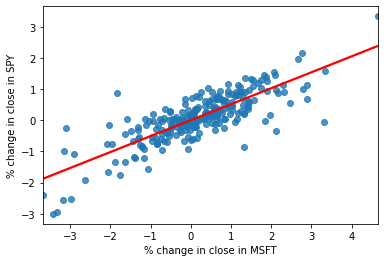

In [ ]:
# use 'merge' function to merge % change data of SP500 and MSFT
new_MSFT = merge('MSFT')

# use seaborn to plot the % changes as a regression
sns.regplot(x = "% change in close in MSFT", 
            y = "% change in close in SPY",
            data = new_MSFT, ci = None,
            line_kws = {'color':'red'})
sns.set(style='dark')
plt.show()

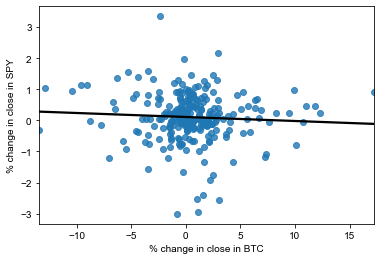

In [ ]:
# use 'mergeCrypto' function to merge % change data of SP500 and BTC
new_BTC = mergeCrypto('BTC')

# use seaborn to plot the % changes as a regression
sns.regplot(x = "% change in close in BTC", 
            y = "% change in close in SPY",
            data = new_BTC, ci = None,
            line_kws = {'color':'black'})
sns.set(style='dark')
plt.show()

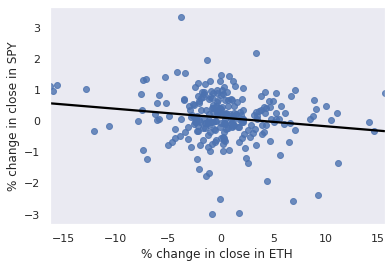

In [ ]:
# use 'mergeCrypto' function to merge % change data of SP500 and ETH
new_ETH = mergeCrypto('ETH')

# use seaborn to plot the % changes as a regression
sns.regplot(x = "% change in close in ETH", 
            y = "% change in close in SPY",
            data = new_ETH, ci = None,
            line_kws = {'color':'black'})
sns.set(style='dark')
plt.show()

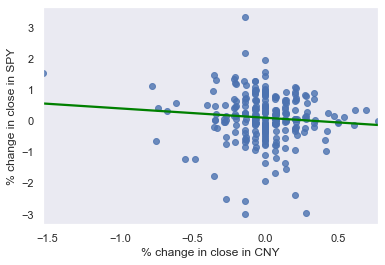

In [ ]:
# use 'mergeCurrency' function to merge % change data of SP500 and CNY
new_CNY = mergeCurrency('CNY')

# use seaborn to plot the % changes as a regression
sns.regplot(x = "% change in close in CNY", 
            y = "% change in close in SPY",
            data = new_CNY, ci = None,
            line_kws = {'color':'green'})
sns.set(style='dark')
plt.show()

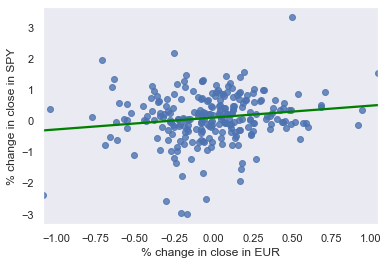

In [ ]:
# use 'mergeCurrency' function to merge % change data of SP500 and EUR
new_EUR = mergeCurrency('EUR')


# use seaborn to plot the % changes as a regression
sns.regplot(x = "% change in close in EUR", 
            y = "% change in close in SPY",
            data = new_EUR, ci = None,
            line_kws = {'color':'green'})
sns.set(style='dark')
plt.show()

### 3c. Statistical Summary
Calculate and display the intercept, coefficient (slope), R^2, and the MSE (Mean Square Error).

In [ ]:
# use 'merge' to bring together % change data of MSFT and SPY
x = merge('MSFT')['% change in close in MSFT']
y = merge('MSFT')['% change in close in SPY']

# run 'linearRegression' function to find values
b0,b1,mse,R2= linearRegression(x,y)
print("Intercept (Regressing SPY on MSFT):", b0)
print("Slope (Regressing SPY on MSFT):", b1)
print("MSE:", mse)
print("R-squared:", R2)

Intercept (Regressing SPY on MSFT): 0.008667691843432246
Slope (Regressing SPY on MSFT): 0.5127737921260107
MSE: 0.21259215272034324
R-squared: 0.6598818164502336


In [ ]:
# isolate % change columns for BTC and SPY
BTC = get_crypto_data("BTC", 'USD')['% change in close in BTC']
BTC = BTC.iloc[1:252]

SP500 = getstock("SPY")['% change in close in SPY']
SP500 = SP500.iloc[1:]

# run 'linearRegression' function to find values
b0,b1,mse,R2 = linearRegression(BTC, SP500)

print("Intercept (Regressing SPY on BTC):", b0)
print("Slope (Regressing SPY on BTC):", b1)
print("MSE:", mse)
print("R-squared:",R2)

Intercept (Regressing SPY on BTC): 0.10957570987389545
Slope (Regressing SPY on BTC): -0.012864812806682694
MSE 0.6227389106917404
R-squared: 0.0037034555604882335


In [ ]:
# isolate % change columns for ETC and SPY
ETH = get_crypto_data("ETH", 'USD')['% change in close in ETH']
ETH = ETH.iloc[1:252]

SP500 = getstock("SPY")['% change in close in SPY']
SP500 = SP500.iloc[1:]

# run 'linearRegression' function to find values
b0,b1,mse,R2 = linearRegression(ETH,SP500)

print("Intercept (Regressing SPY on ETH):", b0)
print("Slope (Regressing SPY on ETH):", b1)
print("MSE:", mse)
print("R-squared:", R2)

Intercept (Regressing SPY on ETH): 0.1092219620670818
Slope (Regressing SPY on ETH): -0.028072623164182086
MSE: 0.6097213064396793
R-squared 0.024529830644073547


In [ ]:
# use 'mergeCurrency' to bring together % change data 
# of CNY and SPY
x = mergeCurrency('CNY')['% change in close in CNY']
y = mergeCurrency('CNY')['% change in close in SPY']

# run 'linearRegression' function to find values
b0,b1,mse,R2 = linearRegression(x,y)

print("Intercept (Regressing SPY on CNY):",b0)
print("Slope (Regressing SPY on ETH):", b1)
print("MSE:", mse)
print("R-squared:",R2)

Intercept (Regressing SPY on CNY): 0.10140219674531965
Slope (Regressing SPY on ETH): -0.3004082895384696
MSE 0.6196550235362367
R-squared 0.008637250548594544


In [ ]:
# use 'mergeCurrency' to bring together % change data 
# of EUR and SPY
x = mergeCurrency('EUR')['% change in close in EUR']
y = mergeCurrency('EUR')['% change in close in SPY']

print("Intercept (Regressing SPY on CNY):", b0)
print("Slope (Regressing SPY on ETH):", b1)
print("MSE:", mse)
print("R-squared",R2)

Intercept (Regressing SPY on CNY): 0.10140219674531965
Slope (Regressing SPY on ETH): -0.3004082895384696
MSE: 0.6196550235362367
R-squared 0.008637250548594544


### 3d. Correlation with SP500
Which asset is highly correlated w/ the SP500 and which asset is the least correlated?
As we can see in the data below, the stock Microsoft has the highest correlation with the SP 500.


**ANSWER:** As we can see from the below correlation matrices:
- Least correlated with SP500 (SPY) = Bitcoin (BTC)
- Most correlated with SP500 (SPY) = Microsoft (MSFT)

In [ ]:
print("Correlation matrix for MSFT and SPY:")
merge('MSFT').corr()

Correlation matrix for MSFT and SPY:



,% change in close in MSFT,% change in close in SPY
% change in close in MSFT,1.000000,0.812331
% change in close in SPY,0.812331,1.000000


In [ ]:
print("Correlation matrix for BTC and SPY:")
mergeCrypto('BTC').corr()

Correlation matrix for BTC and SPY:


,% change in close in BTC,% change in close in SPY
% change in close in BTC,1.000000,-0.060856
% change in close in SPY,-0.060856,1.000000


In [ ]:
print("Correlation matrix for ETH and SPY:")
mergeCrypto('ETH').corr()

,% change in close in ETH,% change in close in SPY
% change in close in ETH,1.00000,-0.15662
% change in close in SPY,-0.15662,1.00000


In [ ]:
print("Correlation matrix for CNY and SPY:")
mergeCurrency('CNY').corr()

Correlation matrix for CNY and SPY:


,% change in close in CNY,% change in close in SPY
% change in close in CNY,1.000000,-0.092937
% change in close in SPY,-0.092937,1.000000


In [ ]:
print("Correlation matrix for EUR and SPY:")
mergeCurrency('EUR').corr()

Correlation matrix for EUR and SPY:


,% change in close in EUR,% change in close in SPY
% change in close in EUR,1.00000,0.15334
% change in close in SPY,0.15334,1.00000
